## Customer Segmentation

1. **Data Preparation**

Load all modules that would be utilized in this notebook

In [1]:
import sys
print(sys.executable)

C:\Users\Sillians\Anaconda3\python.exe


In [2]:
!pip install plotly

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools


from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

Then, will load the `data`. Once done, I also give some basic informations on the content of the dataframe: the type of the various variables, the `number of null values` and their `percentage` with respect to the `total number of entries`:

In [4]:
# Load and read the dataset
df_init = pd.read_csv('data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_init.shape)

Dataframe dimensions: (541909, 8)


In [5]:
df_init.head(5) # display five rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [6]:
# Check for Invoiceno unique numbers
# check for how unique the Invoiceno are related to Counrty, CustomerId, and maybe StockCode
# Get more information from each Feature

In [8]:
df_init.dtypes  # data type

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [9]:
df_init.isnull().sum()  # check for null values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
df_init.shape[0]  # number of rows

541909

In [11]:
df_init['InvoiceDate'] = pd.to_datetime(df_init['InvoiceDate'])

# Get some infos on columns types and numer of null values

# Using the different columns transpose the datatypes of each column as its respective row/value 
# To enable us get more intuition about the data type
col_info = pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'}) 

# Sum the null values of each variable, transpose them(row name (null values (nb))) and append them to the col_info dataframe
col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))

# Divide the sum null values by the total number of rows of our dataset, transpose and append to the col_info dataframe
# This will give us the percentage value of missing data from that column/variable
col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.rename
                           (index={0:'null values (%)'}))

In [13]:
display(col_info)  # display the col_info dataframe

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


As seen from the above dataframe, is obvious that the `CustomerID` contributed to 25% of missing data

In [14]:
# show first 5 rows
display(df_init[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [15]:
# You can imploy other means to replace missing data, but be sure this doesn't bring bias in your data
# scikit-learn Simpleimputer is a great estimator that can be use to actualise this.
# It might be quite ideal to drop the missing data in CustomerID as it contributes 25% of missing data

While looking at the number of `null values` in the dataframe, it is interesting to note that  `25%` of the entries are not assigned to `a/some particular customer(s)`. With the data available, it is impossible to impute values for the user and these entries are thus useless for this Project. So I'll delete them from the dataframe:

In [16]:
# I will have to drop the missing values/rows from the CustomerID
df_init.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_init.shape)

Dataframe dimensions: (406829, 8)


In [17]:
# Giving some infos on columns types and number of null values
col_info = pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'})
col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))

col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.
                           rename(index={0:'null values (%)'}))
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [18]:
# check data type
df_init.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [19]:
# there seem not to be any missing value in our dataset
df_init.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Having removed all `missing values`, looks like we have a dataframe filled at `100%` for all variables! Now, I'd check for `duplicate entries` and delete them as well

In [20]:
df_init['Country'].duplicated().value_counts()

True     406792
False        37
Name: Country, dtype: int64

In [21]:
df_init['InvoiceNo'].duplicated().value_counts()

True     384639
False     22190
Name: InvoiceNo, dtype: int64

Read this blog  <a href="https://www.impactbnd.com/blog/reasons-duplicate-data-is-killing-your-marketing-and-sales-returns">9 Real-World Reasons Duplicate Data Is Killing Your Marketing & Sales Returns</a>   to know why I'm deleting duplicate entries 

In [20]:
print('Duplicate Entries: {}'.format(df_init.duplicated().sum()))
df_init.drop_duplicates(inplace = True)

Duplicate Entries: 5225


In [28]:
print("Shape of the data set after droping duplicate entries :", format(df_init.shape))

Shape of the data set after droping duplicate entries : (406829, 8)


### Data Exploration and exploration of the variable contents

This dataframe contains 8 variables that correspond to:

* **InvoiceNo:** Invoice number. `Nominal`, a `6-digit integral number` uniquely assigned to each `transaction`. If this code starts with letter `'c'`, it indicates a `cancellation`.

* **StockCode:** Product (item) code. `Nominal`, a `5-digit integral number uniquely` assigned to each `distinct product`.

* **Description:** Product (item) name. `Nominal`.

* **Quantity:** The `quantities` of each product (item) `per transaction`. `Numeric`.

* **InvoiceDate:** `Invoice Date` and `time`. `Numeric`, the day and time when each `transaction` was generated.

* **UnitPrice:** `Unit price`. `Numeric`, `Product price` per unit in `sterling`.

* **CustomerID:** `Customer number`. `Nominal`, a `5-digit integral number uniquely` assigned to each customer.
                
* **Country:** `Country name`. `Nominal`, the name of the country where each `customer resides`.

### Countries

A quick look at the `respective countries` from which `orders` were made

In [29]:
# group the CustomerId, InvoiceNo and Country column in the following order and take count
temp_cou = df_init[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()

In [30]:
# this displays the individual customers IDs', different InvoiceNo based on dates of purchase and the customer's country
temp_cou

Empty DataFrame
Columns: []
Index: [(12346, 541431, United Kingdom), (12346, C541433, United Kingdom), (12347, 537626, Iceland), (12347, 542237, Iceland), (12347, 549222, Iceland), (12347, 556201, Iceland), (12347, 562032, Iceland), (12347, 573511, Iceland), (12347, 581180, Iceland), (12348, 539318, Finland), (12348, 541998, Finland), (12348, 548955, Finland), (12348, 568172, Finland), (12349, 577609, Italy), (12350, 543037, Norway), (12352, 544156, Norway), (12352, 545323, Norway), (12352, 545332, Norway), (12352, 546869, Norway), (12352, 547390, Norway), (12352, 567505, Norway), (12352, 568699, Norway), (12352, 574275, Norway), (12352, C545329, Norway), (12352, C545330, Norway), (12352, C547388, Norway), (12353, 553900, Bahrain), (12354, 550911, Spain), (12355, 552449, Bahrain), (12356, 541430, Portugal), (12356, 549435, Portugal), (12356, 576895, Portugal), (12357, 574740, Switzerland), (12358, 559707, Austria), (12358, 581232, Austria), (12359, 540946, Cyprus), (12359, 543370, Cyprus), (12359, 555477, Cyprus), (12359, 571034, Cyprus), (12359, C549955, Cyprus), (12359, C580165, Cyprus), (12360, 554132, Austria), (12360, 563749, Austria), (12360, 571705, Austria), (12361, 545017, Belgium), (12362, 544203, Belgium), (12362, 551346, Belgium), (12362, 559295, Belgium), (12362, 563037, Belgium), (12362, 568651, Belgium), (12362, 570667, Belgium), (12362, 572887, Belgium), (12362, 573173, Belgium), (12362, 574329, Belgium), (12362, 580979, Belgium), (12362, C544902, Belgium), (12362, C563752, Belgium), (12362, C579178, Belgium), (12363, 549687, Unspecified), (12363, 563947, Unspecified), (12364, 563854, Belgium), (12364, 567897, Belgium), (12364, 573401, Belgium), (12364, 580152, Belgium), (12365, 544574, Cyprus), (12365, 544578, Cyprus), (12365, C544577, Cyprus), (12367, 580716, Denmark), (12370, 538826, Cyprus), (12370, 539330, Austria), (12370, 546236, Cyprus), (12370, 571905, Cyprus), (12371, 570521, Switzerland), (12371, 572770, Switzerland), (12372, 544157, Denmark), (12372, 552731, Denmark), (12372, 568872, Denmark), (12373, 542887, Austria), (12374, 576345, Austria), (12375, 565333, Finland), (12375, 579281, Finland), (12375, C581071, Finland), (12377, 539488, Switzerland), (12377, 542586, Switzerland), (12378, 562046, Switzerland), (12379, 557789, Belgium), (12379, 567196, Belgium), (12379, C559193, Belgium), (12380, 555739, Belgium), (12380, 567928, Belgium), (12380, 571187, Belgium), (12380, 577180, Belgium), (12380, C572532, Belgium), (12381, 563100, Norway), (12381, 570681, Norway), (12381, 570725, Norway), (12381, 574694, Norway), (12381, 580638, Norway), (12381, C565050, Norway), (12383, 539840, Belgium), ...]

[22190 rows x 0 columns]

In [34]:
# Add an index number 
# reset_index() is a method to reset index of a Data Frame.
# reset_index() method sets a list of integer ranging from 0 to length of data as index.
temp_cou = temp_cou.reset_index(drop = False)

In [35]:
temp_cou

,level_0,index,CustomerID,InvoiceNo,Country
0,0,0,12346,541431,United Kingdom
1,1,1,12346,C541433,United Kingdom
2,2,2,12347,537626,Iceland
3,3,3,12347,542237,Iceland
4,4,4,12347,549222,Iceland
...,...,...,...,...,...
22185,22185,22185,18283,579673,United Kingdom
22186,22186,22186,18283,580872,United Kingdom
22187,22187,22187,18287,554065,United Kingdom
22188,22188,22188,18287,570715,United Kingdom


In [36]:
# Take count of the number of unique countries
countries = temp_cou['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


Let's display the result on a chloropleth map

In [37]:
countries.index

Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Spain',
       'Netherlands', 'Switzerland', 'Portugal', 'Australia', 'Italy',
       'Finland', 'Sweden', 'Norway', 'Channel Islands', 'Japan', 'Poland',
       'Denmark', 'Cyprus', 'Austria', 'Malta', 'Singapore', 'Unspecified',
       'Iceland', 'USA', 'Israel', 'Canada', 'Greece', 'Czech Republic',
       'European Community', 'Lithuania', 'United Arab Emirates', 'Bahrain',
       'Saudi Arabia', 'RSA', 'Brazil', 'Lebanon'],
      dtype='object')

In [38]:
countries

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Malta                      10
Singapore                  10
Unspecified                 8
Iceland                     7
USA                         7
Israel                      6
Canada                      6
Greece                      6
Czech Republic              5
European Community          5
Lithuania                   4
United Arab Emirates        3
Bahrain                     2
Saudi Arab

A `choropleth map` is a type of thematic map in which areas are shaded or patterned in proportion to a statistical variable that represents an aggregate summary of a geographic characteristic within each area, such as population density or per-capita income.

In [40]:
# Customize the data points
data = dict(type='choropleth', 
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'Order no.'},
            colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
            reversescale = False)

In [41]:
layout = dict(title='Number of orders per country',
              geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

From the Map, You'll see that the dataset is largely dominated by orders made from this first five Countries

* `United Knigdom with 19857 customers`

* `Germany with 603 customers`

* `France with 458 customers`

* `EIRE with 319 customers`

* `Belgium with 119 customers`

### Customers and products

The dataframe contains `401,604 entries`. What are the number of users and products in these entries?

In [42]:
df_init

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [43]:
len(df_init['CustomerID'].value_counts())

4372

In [44]:
pd.DataFrame([{'products': len(df_init['StockCode'].value_counts()),    
               'transactions': len(df_init['InvoiceNo'].value_counts()),
               'customers': len(df_init['CustomerID'].value_counts()),}], 
             columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


* The Dataframe above shows that the data concern `4372` users and that they bought `3684` different products. 

* The total number of `transactions` carried out is of the order of  `∼ 22190`.

In every `transaction` a product is purchased, Let's determine the `number of products purchased` in every transaction:

In [47]:
temp_pro = df_init.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

# Rename the InvoiceDate to number of products
nb_products_per_basket = temp_pro.rename(columns = {'InvoiceDate':'Number of products'})

# Sort in Ascending order based on CustomerID
nb_products_per_basket[:10].sort_values('CustomerID') # List first 10 values

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


#### The first lines of this list shows several things worthy of interest:

* the existence of entries with the prefix `C` for the `InvoiceNo variable`: this indicates transactions that have been canceled.

* the existence of users who only came `once` and only `purchased` one `product` (e.g. `nº12346`)

* the existence of `frequent users` that buy a large number of items at each order.

### Cancelling orders

The best way to approach this is that I'll count the number of `transactions` corresponding to `canceled orders`:

In [48]:
# Create a new column(order_canceled) and assign/take count of the canceled InvoiceNo values
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x)) 
display(nb_products_per_basket[:5])

# Sum total of order_canceled
n1 = nb_products_per_basket['order_canceled'].sum()

# Sum of rows
n2 = nb_products_per_basket.shape[0]

# Divide by 100 to get the percentage value
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


Note that the number of cancellations is quite large (`∼ 16%` of the total number of `transactions`). Now, let's look at the first lines of the dataframe:

In [49]:
display(df_init.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286628,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347,Iceland
72263,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347,Iceland
72264,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347,Iceland


On these few lines, we see that when an order is `canceled`, we have another `transactions` in the dataframe, mostly identical except for the `Quantity` and `InvoiceDate variables`. I'll check if this is true for all the entries. 
To do this, I decide to locate the `entries` that indicate a `negative quantity` and check if there is `systematically` an order indicating the `same quantity (but positive)`, with the `same description (CustomerID, Description and UnitPrice)`:

In [50]:
# Check any negative value in the Quantity variable / entries that indicate a negative quantity
df_check = df_init[df_init['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]

# Iterate through the rows, check if there is an order indicating same quantity(but positive), with same description(CustomerID
# , Description, and UnitPrice)
for index, col in  df_check.iterrows():
    if df_init[(df_init['CustomerID'] == col[0]) & (df_init['Quantity'] == -col[1]) 
                & (df_init['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [99]:
df_check = df_init[df_init['Quantity'] < 0][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df_check

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527,-1,D,Discount,27.50
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
...,...,...,...,...,...
540449,14397,-11,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83
541541,15498,-1,M,Manual,224.69
541715,15311,-5,21258,VICTORIAN SEWING BOX LARGE,10.95
541716,17315,-1,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25


In [113]:
# df_new = df_check.loc[df_check.CustomerID.isin([17548])]
# df_new

We see that the `initial hypothesis` is not fulfilled because of the existence of a `'Discount'` entry. I check again the hypothesis but this time discarding the `'Discount'` entries

In [114]:
# Basically doing what the code above does, but will discard the `Discount` column
df_check = df_init[(df_init['Quantity'] < 0) & (df_init['Description'] != 'Discount')][['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_init[(df_init['CustomerID'] == col[0]) & (df_init['Quantity'] == -col[1]) & 
               (df_init['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the `initial hypothesis` is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before `December 2010` (the point of entry of the database). Below, I make a census of the `cancel orders` and check for the existence of counterparts:

In [115]:
df_cleaned = df_init.copy(deep = True)  # made a deep copy of our dataset
df_cleaned['QuantityCanceled'] = 0      # initialize the new varaible in the dataframe

# 
entry_to_remove = [] ; doubtfull_entry = []


for index, col in  df_init.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_init[(df_init['CustomerID'] == col['CustomerID']) &
                         (df_init['StockCode']  == col['StockCode']) & 
                         (df_init['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_init['Quantity']   > 0)].copy()
    
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
        
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index) 
        
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

In the above function, I checked the two cases:

* a cancel order exists without counterpart

* there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the `doubtfull_entry` and `entry_to_remove` lists whose sizes are:

In [116]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7543
doubtfull_entry: 1229


Among these entries, the lines listed in the `doubtfull_entry` list correspond to the entries indicating a `cancellation` but for which there is no command beforehand. In practice, I decided to delete all of these entries, which count respectively for  `∼ 1.4%` and `0.2%` of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [117]:
# Drop the `entry_to_remove` and `doubtfull_entry` accross the row axis
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [121]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries.head(5)

nb of entries to delete: 56


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
58496,C541245,85036C,ROSE 1 WICK MORRIS BOXED CANDLE,-12,2011-01-16 12:40:00,4.25,15535,United Kingdom,0
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0


In [125]:
remaining_entries.sort_index(axis=0)[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
58496,C541245,85036C,ROSE 1 WICK MORRIS BOXED CANDLE,-12,2011-01-16 12:40:00,4.25,15535,United Kingdom,0
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [130]:
# entry = df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]
# print(entry)

In [132]:
# df_cleaned[(df_cleaned['CustomerID'] == 15358) & (df_cleaned['StockCode'] == '84535B')]

In [133]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [134]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398057 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo           398057 non-null object
StockCode           398057 non-null object
Description         398057 non-null object
Quantity            398057 non-null int64
InvoiceDate         398057 non-null datetime64[ns]
UnitPrice           398057 non-null float64
CustomerID          398057 non-null object
Country             398057 non-null object
QuantityCanceled    398057 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 30.4+ MB


We see that the quantity canceled is greater than the sum of the previous purchases.

### StockCode

Above, it has been seen that some values of the `StockCode` variable indicate a particular transaction (i.e. `D for Discount`). let's check the contents of this variable by looking for the set of codes that would contain only letters:

In [135]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [136]:
# Pick this uniques characters from Description that corresponds to the special codes
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


We see that there are several types of `peculiar transactions`, connected e.g. to `port charges` or `bank charges`.

### Basket Price

Will create a `new variable` that indicates the `total price of every purchase`:

In [137]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.00
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.00
428987,573511,23422,PANTRY HOOK BALLOON WHISK,12,2011-10-31 12:25:00,2.08,12347,Iceland,0,24.96
428988,573511,23420,PANTRY HOOK TEA STRAINER,12,2011-10-31 12:25:00,2.08,12347,Iceland,0,24.96
428989,573511,22699,ROSES REGENCY TEACUP AND SAUCER,18,2011-10-31 12:25:00,2.95,12347,Iceland,0,53.10


In [138]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398057 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo           398057 non-null object
StockCode           398057 non-null object
Description         398057 non-null object
Quantity            398057 non-null int64
InvoiceDate         398057 non-null datetime64[ns]
UnitPrice           398057 non-null float64
CustomerID          398057 non-null object
Country             398057 non-null object
QuantityCanceled    398057 non-null int64
TotalPrice          398057 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 33.4+ MB


Each entry of the dataframe indicates `prizes` for a `single kind of product`. Hence, orders are split on several lines. Will have to collect all the purchases made during a single order to recover the total order prize:

In [140]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
df_cleaned[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceDate_int
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1291191960000000000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,1291191960000000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000


In [141]:
# sum of purchases / user & order
temp_sum = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp_sum.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp_date = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp_date['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


In [142]:
basket_price.tail(6)

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
18630,18283,578262,313.65,2011-11-23 13:27:00.000002048
18631,18283,579673,223.61,2011-11-30 12:58:59.999998464
18632,18283,580872,208.00,2011-12-06 12:02:00.000001792
18633,18287,554065,765.28,2011-05-22 10:38:59.999998976
18634,18287,570715,1001.32,2011-10-12 10:22:59.999998720
18635,18287,573167,70.68,2011-10-28 09:29:00.000000000


To get a global/clear view of the type of order performed in this dataset, I determine how the `purchases` are divided according to `total prizes`

In [147]:
basket_price.max(), basket_price.min()

(CustomerID                    18287
 InvoiceNo                    581587
 Basket Price                  30757
 InvoiceDate     2011-12-09 12:50:00
 dtype: object, CustomerID                    12347
 InvoiceNo                    536365
 Basket Price                   0.38
 InvoiceDate     2010-12-01 08:26:00
 dtype: object)

In [149]:
nice = [23, 4, 56, 7, 89, 0.45, 56]
print(enumerate(nice))

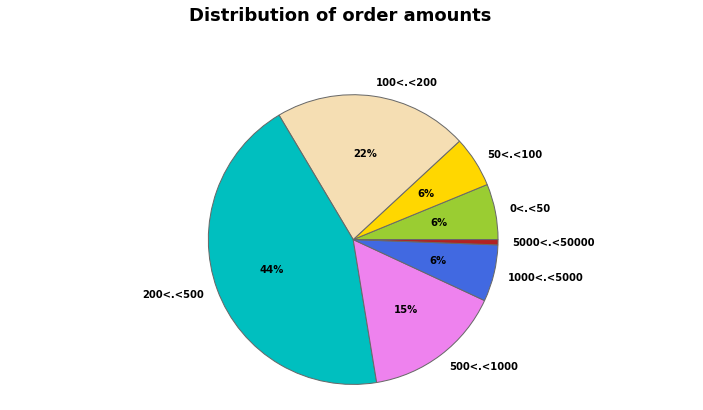

In [150]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]

count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    


# Representation of the number of purchases / amount    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that  `∼65%` of purchases give prizes in excess of `£200`.

###  Insight on product categories

In the `dataframe`, `products` are uniquely identified through the `StockCode variable`. A short description of the products is given in the `Description variable`. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

### Products Description

As a first step, I extract from the `Description variable` the information that will prove useful. The function below will handle this task:

In [151]:
# part-of-speech 
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")  # NLTK stemmer (Snowball stemmer)
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
                
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
            
    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as `input` the dataframe and `analyzes the content` of the `Description` column by performing the following operations:

* extract the names (proper, common) appearing in the products description

* for each name, I extract the root of the word and aggregate the set of names associated with this particular root

* count the number of times each root appears in the dataframe

* when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)


The first step of the `analysis` is to retrieve the list of products:

In [152]:
df_products = pd.DataFrame(df_init['Description'].unique()).rename(columns = {0:'Description'})

In [153]:
df_products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3891,"LETTER ""W"" BLING KEY RING"
3892,"LETTER ""Z"" BLING KEY RING"
3893,PINK CRYSTAL SKULL PHONE CHARM
3894,CREAM HANGING HEART T-LIGHT HOLDER


Once this list is created, Will have to use the function I previously defined in order to analyze the `description` of the various products:

In [154]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sillians\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [155]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

No. of keywords in variable 'Description': 1484


The execution of this function returns three variables:

* `keywords:` the list of extracted keywords

* `keywords_roots:` a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots

* `count_keywords:` dictionary listing the number of times every word is used

At this point, I'll convert the `count_keywords` dictionary into a list, to sort the `keywords` according to their occurences:

In [156]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I'll create a `representation` of the `most common keywords`:

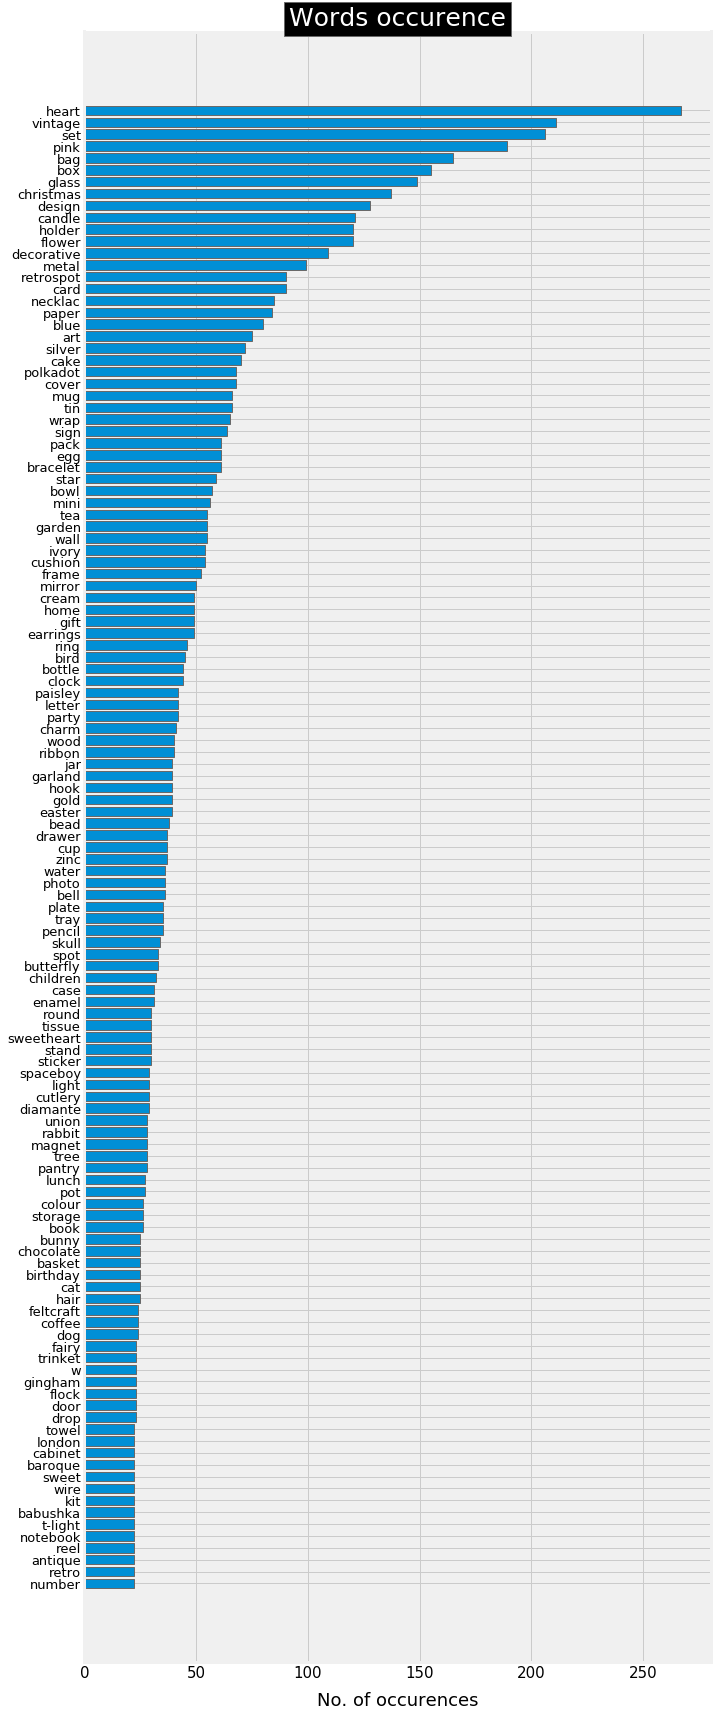

In [162]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)


plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 30))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()


plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### Defining product categories

The list that was obtained contains more than `1400 keywords` and the `most frequent` ones appear in more than `200 products`. However, while examinating the content of the list, I noticed that some names doesn't `depict any information`. Others do not carry enough information, like `colors`. Therefore, I'll discard these words from the analysis that follows and also, I'll decide to consider only the words that appear more than `13 times`.

In [163]:
list_products = []


# Loop through the count_keywords and check the different conditions
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
    

# list most kept words
list_products.sort(key = lambda x:x[1], reverse = True)
print('words kept:', len(list_products))

words kept: 193


#### Data encoding

Now I will use these keywords to create groups of product.where the `ai,j`  coefficient is `1` if the description of the product `i` contains the word  `j` , and `0` otherwise.

In [164]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

The  `X  matrix` indicates the words contained in the description of the products using the `one-hot-encoding` principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add `6 extra columns` to this matrix, where I indicate the price range of the products:

In [165]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [166]:
print("{:<8} {:<20} \n".format('range', 'no. products') + 20*'-')

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    no. products         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       608                 
5<.<10      468                 
.>10        156                 


### Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the `Hamming's metric`. Note that the `kmeans` method of sklearn uses an `Euclidean distance` that can be used, but it is not to the best choice in the case of `categorical variables`. However, in order to use the `Hamming's metric`, we need to use the `kmodes` package which is not available on the current platform. Hence, I use the kmeans method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the `silhouette score`:

In [167]:
matrix = X.as_matrix()

for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10076813899896635
For n_clusters = 4 The average silhouette_score is : 0.12474129114190229
For n_clusters = 5 The average silhouette_score is : 0.1267041111563961
For n_clusters = 6 The average silhouette_score is : 0.15142903934780486
For n_clusters = 7 The average silhouette_score is : 0.14843992292647243
For n_clusters = 8 The average silhouette_score is : 0.14391714824784
For n_clusters = 9 The average silhouette_score is : 0.15747353702737685


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  `0.1±0.05`  will be obtained for all clusters with `n_clusters  >  3` (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond `5 clusters`, some clusters contained very few elements. I therefore choose to separate the dataset into `5 clusters`. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around `0.15`:

In [169]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14523922939293546


### Characterizing the content of clusters

I check the number of `elements` in every `class`:

In [170]:
pd.Series(clusters).value_counts()

3    1162
0     964
1     673
4     608
2     471
dtype: int64

#### a. Silhouette intra-cluster score

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html">sklearn documentation:</a>

In [171]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        
        
        
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
           
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

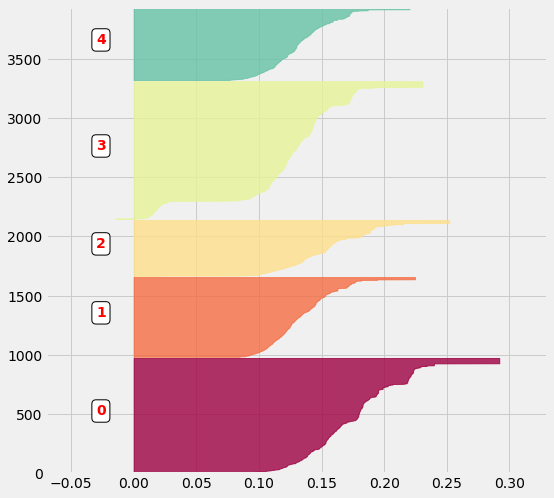

In [172]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

#### b. Word Cloud

Now we can have a look at the type of objects that each `cluster` represents. In order to obtain a `global view` of their contents, I determine which keywords are the most frequent in each of them

In [173]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

The result outputed as `wordclouds`:

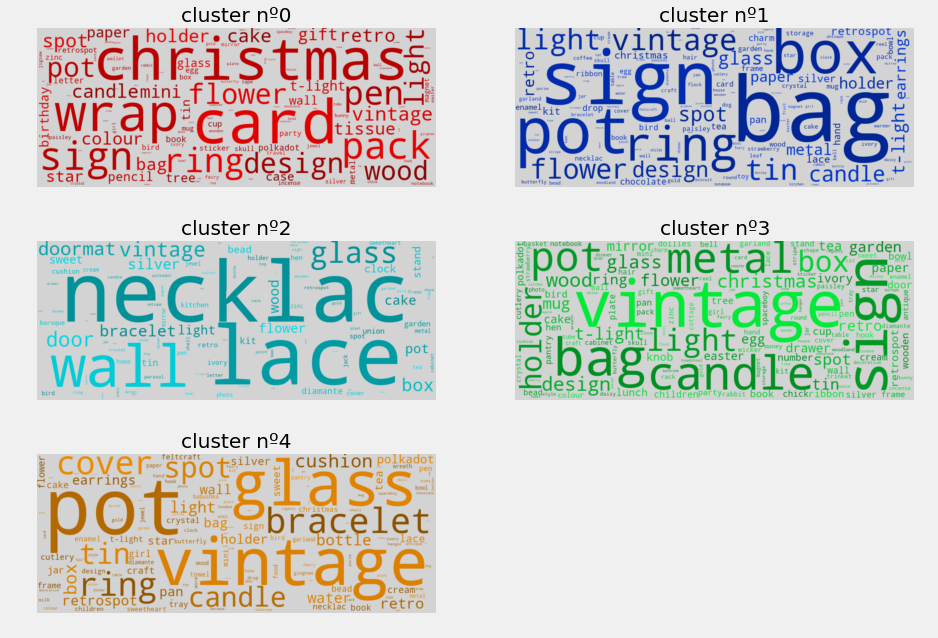

In [174]:
#
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
        
    #
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
    
#
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1) 

From the above representation, we can see that for example, one of the clusters contains objects that could be associated with `gifts` 
* (`keywords: Christmas, packaging, card, ...`). 

Another cluster would rather contain `luxury items` and `jewelry` 
* (`keywords: necklace, bracelet, lace, silver, ...`).  

Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

### c. Principal Component Analysis

In order to ensure that these clusters are `truly distinct`, I look at their composition. Given the large number of variables of the `initial matrix`, I first perform a `PCA`:

In [175]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

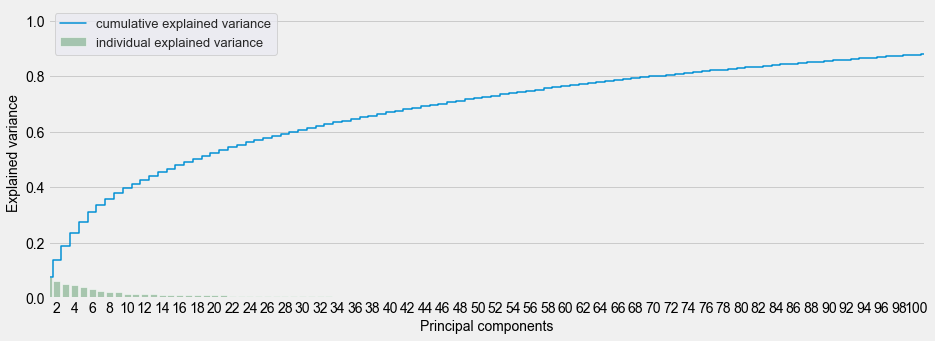

In [176]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')

sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')

plt.xlim(0, 100)


ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is `extremely important:` we need more than `100 components` to explain `90%` of the variance of the data. In practice, I decided to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [177]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

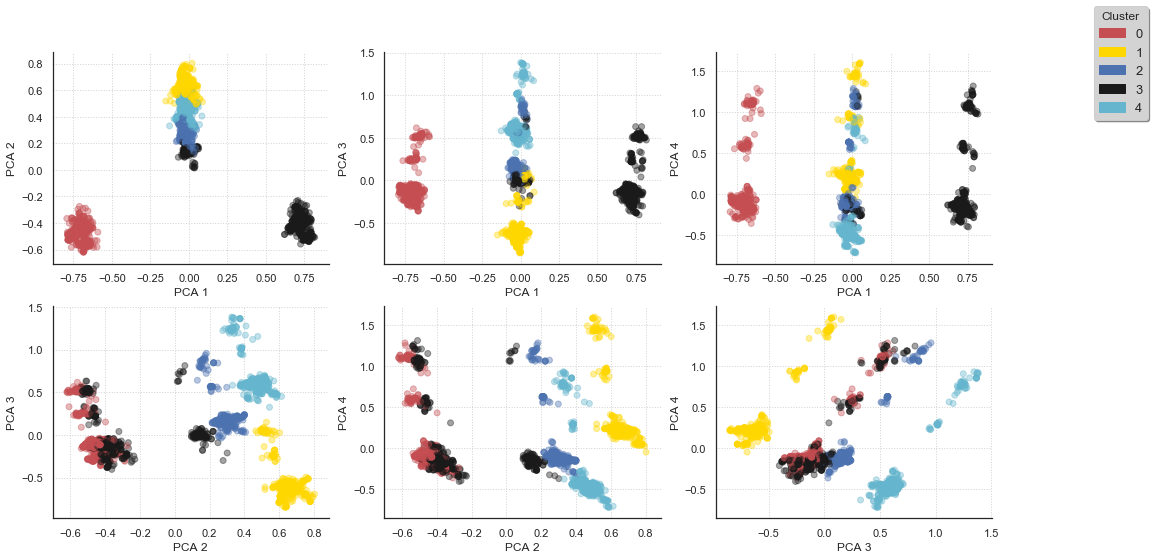

In [178]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

### Customer categories

1.`Formatting data`

In the previous section, the different `products` were grouped in `five clusters`. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable `categ_product` where I indicate the cluster of each product:

In [179]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

#### Grouping products

In a second step, I decided to create the `categ_N` variables (with  `N∈[0:4]` ) that contains the amount spent in each product category:

In [180]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decided to collect the information related to a particular order and put in a single entry. I therefore created a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the `5 categories` of products:

In [181]:
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of the order price / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp
    
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]    

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,23.40,83.40,124.44,187.20,293.35,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,84.34,53.10,0.00,168.75,169.20,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,81.00,71.10,0.00,369.15,115.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,41.40,78.06,19.90,74.40,168.76,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,61.30,119.70,97.80,147.95,158.16,2011-08-02 08:48:00.000000000


#### Separation of data over time

The dataframe `basket_price` contains information for a period of `12 months`. Later, one of the objectives will be to develop a `model capable of characterizing and anticipating the habits of the customers visiting the site` and this, from their first visit. 
In order to be able to `test the model in a realistic way`, I split the `data set` by retaining the first `10 months` to develop the `model` and the following `two months` to test it:

In [182]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [183]:
set_training = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test    = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_training.copy(deep = True)

#### Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the `minimum`, `maximum`,`average amounts` and the `total amount` spent during all the visits:

In [184]:
# number of visits and stats on the basket amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,10.442659,14.524555,8.676179,33.948317,32.408290
1,12348,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,0.000000,61.983931,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,11.692584,27.900718,0.000000,60.406699,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,0.491808,3.370331,14.301006,66.125517,15.711338
4,12353,1,89.00,89.00,89.000000,89.00,0.000000,19.887640,22.359551,57.752809,0.000000


Finally, I define two additional variables that give the number of days elapsed since the first purchase (`FirstPurchase`) and the number of days since the last purchase (`LastPurchase`):

In [185]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,10.442659,14.524555,8.676179,33.948317,32.408290,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,0.000000,61.983931,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,11.692584,27.900718,0.000000,60.406699,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,0.491808,3.370331,14.301006,66.125517,15.711338,2,226
4,12353,1,89.00,89.00,89.000000,89.00,0.000000,19.887640,22.359551,57.752809,0.000000,134,134


A `customer category` of particular interest is that of customers who make only one purchase. One of the `objectives` may be, for example, to target these customers in order to retain them. the fact is that, I find that this type of customer represents `1/3` of the customers listed:

In [186]:
n1_check = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n1_check

1445

In [187]:
n2_check = transactions_per_user.shape[0]
n2_check

3608

In [188]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("no. of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

no. of customers with single purchase: 1445/3608  (40.05%)


#### Creation of customers categories

* `Data encoding`

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [189]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

#
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

In [195]:
matrix

array([[  5.        , 382.52      , 711.79      , ...,   8.67617867,
         33.94831701,  32.40828992],
       [  4.        , 227.44      , 892.8       , ...,   0.        ,
         61.98393092,   0.        ],
       [  1.        , 334.4       , 334.4       , ...,   0.        ,
         60.40669856,   0.        ],
       ...,
       [  1.        ,  98.76      ,  98.76      , ...,   0.        ,
         49.05832321,  13.66950182],
       [ 10.        ,   2.5       , 203.81      , ...,   2.17726896,
         37.33123935,   8.03983331],
       [  1.        , 765.28      , 765.28      , ...,   4.44281831,
         70.68001254,   1.9600669 ]])

In practice, the different variables I selected have quite different ranges of `variation` and before continuing the analysis, I create a `matrix` where these data are standardized:

In [196]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62333703 260.63053271 558.02646702 378.22540357  13.96474964
  21.20317747  15.68380023  32.77707317  16.37677888]


In [197]:
scaled_matrix

array([[ 0.22677507,  0.37483101,  0.13793938, ..., -0.42490758,
         0.06078565,  1.08642889],
       [ 0.06204697, -0.10206658,  0.30032122, ..., -0.95098822,
         1.51578846, -1.10982711],
       [-0.43213731,  0.22685376, -0.20061256, ..., -0.95098822,
         1.43393267, -1.10982711],
       ...,
       [-0.43213731, -0.49777964, -0.41200231, ..., -0.95098822,
         0.84497042, -0.18346767],
       [ 1.05041554, -0.79379564, -0.31776324, ..., -0.81896938,
         0.23635383, -0.56498096],
       [-0.43213731,  1.55188363,  0.1859246 , ..., -0.68159765,
         1.96710097, -0.97699663]])

In the following, I will create `clusters of customers`. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a `PCA` beforehand:

In [198]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of `variance` explained by each of the components:

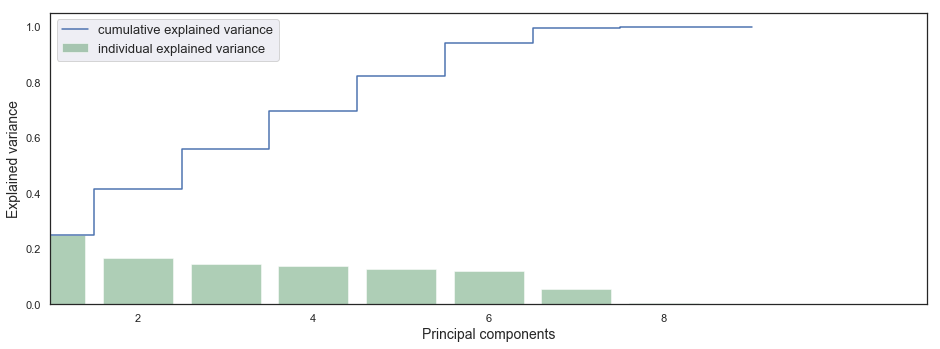

In [199]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

#### Creation of customer categories

At this point, I define clusters of clients from the `standardized matrix` that was defined earlier and using the `k-means algorithm` from scikit-learn. I choose the number of clusters based on the `silhouette score` and I find that the best score is obtained with `11 clusters`:

The `silhouette value` is a measure of how `similar an object` is to its own `cluster (cohesion)` compared to other `clusters (separation)`. The `silhouette ranges` from `−1 to +1`, where a `high value indicates that the object is well matched` to its `own cluster` and `poorly matched to neighboring clusters`. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html">sklearn.metric.silhouette_score</a>

In [200]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.218


At first, I look at the `number of customers` in each `cluster`:

In [201]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no. of customers']).T

,0,6,8,7,1,9,5,2,4,3,10
no. of customers,1538,492,329,302,292,262,193,172,11,9,8


#### Report via the PCA

There is a certain `disparity` in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the `PCA`:

In [202]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

In [204]:
mat.head()

,0,1,2,3,4,5,cluster
0,0.553621,-0.219499,-0.434375,-0.000979,0.248305,1.118498,0
1,0.071145,2.659549,-0.287370,0.416501,1.035934,-0.240676,6
2,-0.112595,1.782148,0.317631,0.058765,-1.164844,-0.019658,6
3,-0.085538,0.949295,-1.203298,1.513273,-0.540102,0.505121,6
4,-0.981803,0.793065,-0.566213,0.743243,-1.380043,-0.684359,6


In order to create a representation of the various clusters:

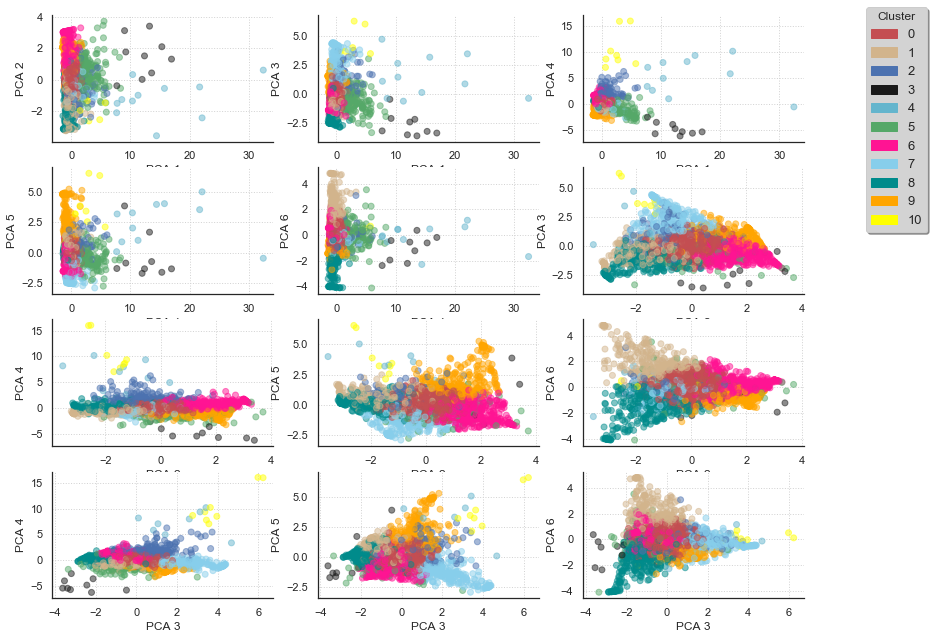

In [205]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first `principal component` allow to separate the `tiniest clusters` from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

#### Intra-cluster silhouette score

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

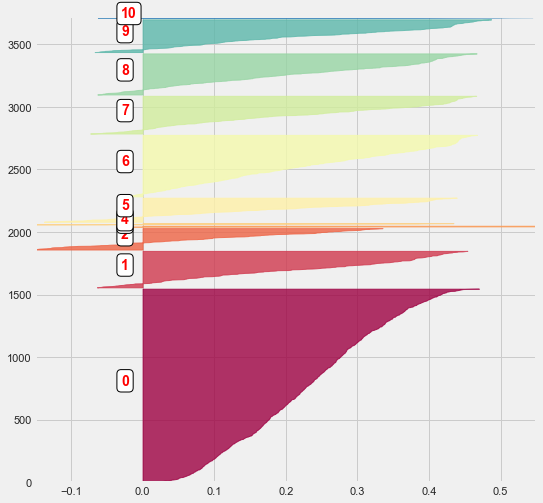

In [206]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

#### Customers morphotype

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers dataframe` a variable that defines the cluster to which each client belongs:

In [207]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the `average baskets price`, the `number of visits` or the `total sums` spent by the clients of the different clusters. I also determine the number of clients in each group (variable size ):

In [208]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


Finally, I `re-organize` the content of the dataframe by ordering the `different clusters`: first, in relation to the `amount spent` in each `product category` and then, according to the `total amount spent`:

In [209]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

    
liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]


merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,9.0,2.225191,197.681031,319.039351,250.406203,592.176565,55.059931,11.292612,5.366070,22.102463,6.178923,262
1,7.0,2.576159,210.914868,382.539371,292.775736,818.013477,7.047158,60.367267,7.536297,17.866260,7.183018,302
2,8.0,2.492401,192.140547,308.886261,244.502298,625.845957,5.209222,11.310447,53.353842,17.156649,12.969839,329
3,6.0,2.367886,199.672398,325.202787,255.557232,632.971913,8.797742,10.716813,7.063377,66.760212,6.664880,492
4,1.0,2.140411,200.195034,339.002774,263.636487,658.623904,6.634273,14.251211,10.809732,17.202660,51.141731,292
5,0.0,3.145644,225.336828,457.435995,332.830155,1056.980625,13.639757,21.628079,14.851666,32.828330,17.054745,1538
6,5.0,1.725389,1056.334870,1412.366378,1220.179846,2240.322596,12.400569,21.136994,13.606138,35.740422,17.116225,193
7,3.0,1.222222,3902.927778,4065.565556,3984.246667,5033.514444,26.409401,11.844859,19.516059,27.704642,14.525040,9
8,2.0,17.273256,87.087384,1383.928198,522.778366,8678.172733,12.087575,24.417271,15.797759,31.158593,16.556515,172
9,10.0,87.125000,20.862500,2654.426250,458.073015,37444.943750,11.454087,24.597817,16.464519,33.517921,13.965656,8


#### Customers morphology

Finally, I created a representation of the different `morphotypes`. To do this, I define a class to create `"Radar Charts"` (which has been adapted from this kernel):

In [210]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

The code below shows a global view of the content of each cluster:

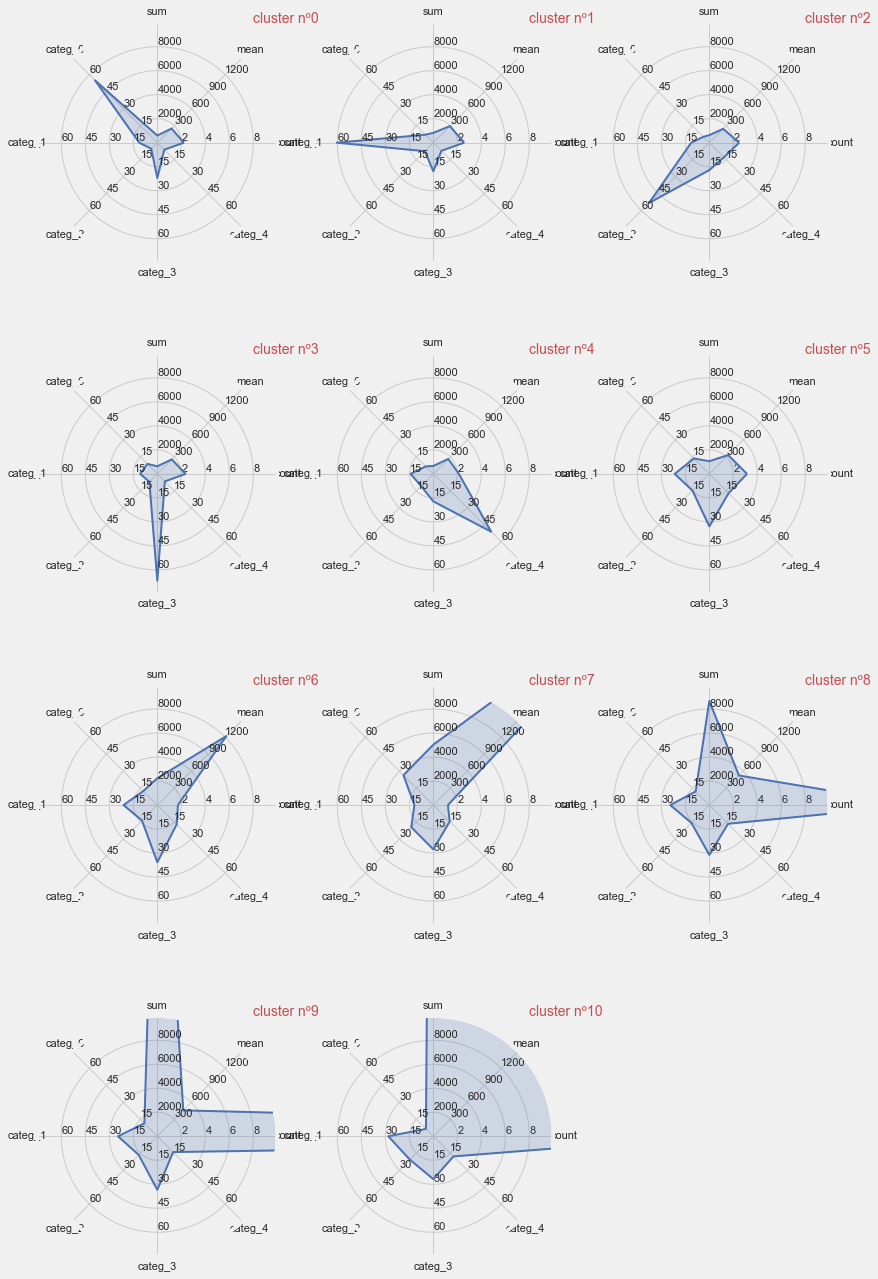

In [211]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    
    
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

It can be seen, for example, that the first `5 clusters` correspond to a `strong preponderance`(the quality or fact of being greater in number, quantity, or importance) of purchases in a particular category of products. Other clusters will differ from basket averages(mean), the `total sum spent` by the clients (sum) or the `total number` of visits made (count).

#### Classification of customers

In this part, the objective will be to `adjust a classifier` that will `classify constumers` in their different `client categories` that were established in the previous section. The objective is to make this `classification` possible at the first visit. To fulfill this objective, I will test several `classifiers` implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [212]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    # train on the x_train and y_train data
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    # predict/validate on the held-out data
    def predict(self, x):
        return self.clf.predict(x)
    
    # hyperparameter tuning using GridsearchCV
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
    
    # fit after tuning
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
    
    # predict
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the `class` to which a `client` belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [213]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [215]:
Y.value_counts()

0     1538
6      492
8      329
7      302
1      292
9      262
5      193
2      172
4       11
3        9
10       8
Name: cluster, dtype: int64

In [217]:
X.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
0,558.172000,10.442659,14.524555,8.676179,33.948317,32.408290
1,449.310000,38.016069,0.000000,0.000000,61.983931,0.000000
2,334.400000,11.692584,27.900718,0.000000,60.406699,0.000000
3,345.663333,0.491808,3.370331,14.301006,66.125517,15.711338
4,89.000000,0.000000,19.887640,22.359551,57.752809,0.000000


Finally, I split the `dataset` in `train` and `test sets`:

In [218]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=0)

In [219]:
X_train.shape, Y_train.shape

((2886, 6), (2886,))

In [220]:
X_test.shape, Y_test.shape

((722, 6), (722,))

### `Support Vector Machine Classifier (SVC)`

The `first classifier` I use is the `SVC classifier`. In order to use it, I create an `instance of the Class_Fit class` and then call `grid_search()`. When calling this method, I provide as parameters:

* the `hyperparameters` for which I will seek an `optimal value`.

* the `number of folds` to be used for `cross-validation`.

In [221]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this `instance` is created, I adjust the `classifier` to the `training data`:

In [222]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the `test data`:

In [223]:
svc.grid_predict(X_test, Y_test)

Precision: 77.70 % 


#### Confusion matrix

The `accuracy` of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an `imbalance` in size between the classes obtained. In particular, one class contains around `40%` of the clients. It is therefore interesting to look at how the `predictions` and `real values` compare to the breasts of the different classes. This is the subject of the `confusion matrices` and to represent them, I use the code of the <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html">sklearn documentation</a>

In [224]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I `create` the following representation:

Confusion matrix, without normalization


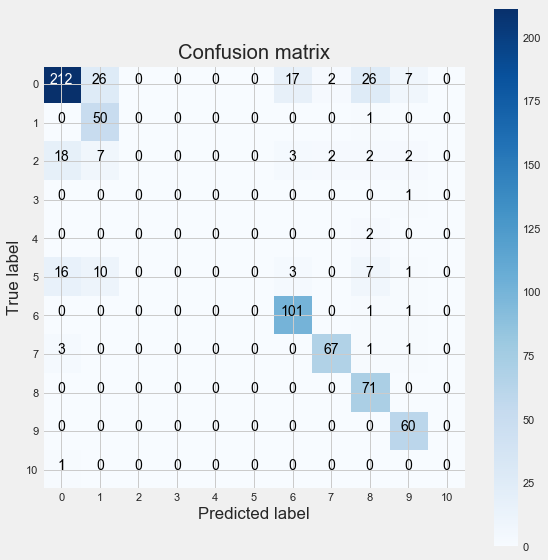

In [225]:
class_names = [i for i in range(11)]

cnf_matrix = confusion_matrix(Y_test, svc.predictions) 

np.set_printoptions(precision=2)

plt.figure(figsize = (8,8))

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

#### Learning curve


A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-%20self-examples-model-selection-pad-learning-curve-py">scikit learn documentation code</a>

In [226]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the `SVC classifier`:

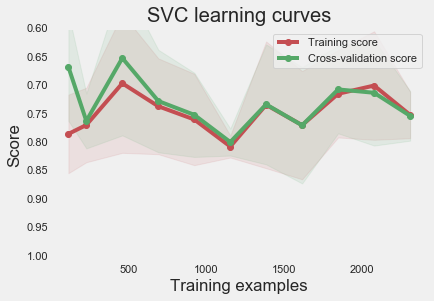

In [227]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the `train` and `cross-validation` curves `converge` towards the same limit when the sample size increases. This is typical of modeling with `low variance` and proves that the model does not suffer from `overfitting`. Also, we can see that the `accuracy` of the training curve is correct which is synonymous of a `low bias`. Hence the model does not `underfit the data`.

#### Logistic Regression

I now consider the `logistic regression classifier`. As before, I create an instance of the `Class_Fit class`, adjust the model on the `training data` and see how the `predictions compare to the real values`:

In [228]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)

# fit on training data
lr.grid_fit(X = X_train, Y = Y_train)

# predict on test data
lr.grid_predict(X_test, Y_test)

Precision: 90.03 % 


Then, I plot the `learning curve` to have a feeling of the `quality of the model`:

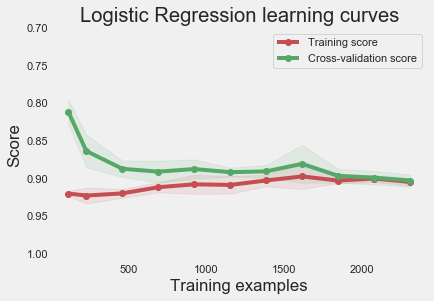

In [229]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### k-Nearest Neighbors

In [230]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)

# fit on training data
knn.grid_fit(X = X_train, Y = Y_train)

# predict on test data
knn.grid_predict(X_test, Y_test)

Precision: 77.70 % 


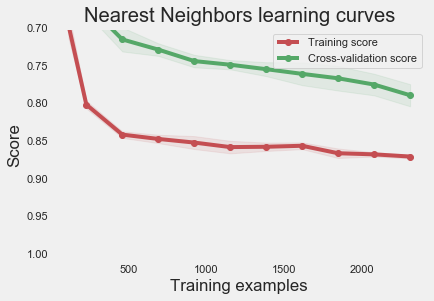

In [231]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Decision Tree

In [232]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)

# fit on training data
tr.grid_fit(X = X_train, Y = Y_train)

# predict on test data
tr.grid_predict(X_test, Y_test)

Precision: 82.41 % 


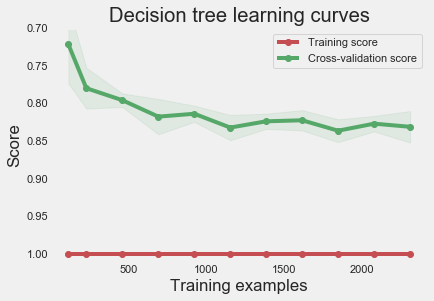

In [233]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Random Forest

In [235]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}

rf.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
rf.grid_fit(X = X_train, Y = Y_train)

# predict on test data
rf.grid_predict(X_test, Y_test)

Precision: 90.30 % 


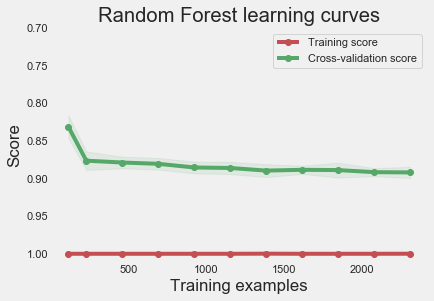

In [236]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### AdaBoost Classifier

In [237]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
ada.grid_fit(X = X_train, Y = Y_train)

# predict on test data
ada.grid_predict(X_test, Y_test)

Precision: 52.63 % 


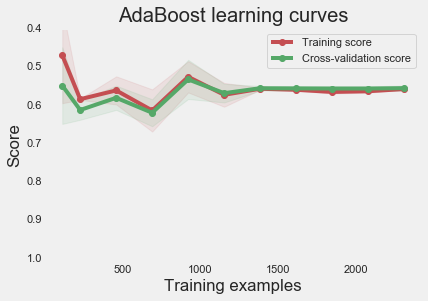

In [238]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Gradient Boosting Classifier

In [239]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
gb.grid_fit(X = X_train, Y = Y_train)

# predict on test data
gb.grid_predict(X_test, Y_test)

Precision: 90.17 % 


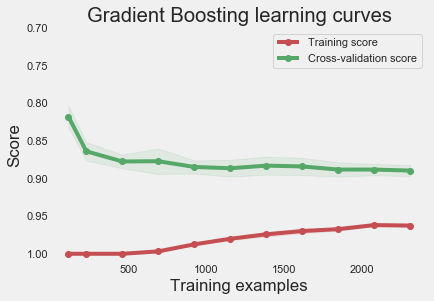

In [240]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Let's vote !

Finally, the results of the different `classifiers` presented in the previous sections can be combined to improve the `classification model`. This can be achieved by selecting the `customer category` as the one indicated by the `majority of classifiers`. To do this, I use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html">`VotingClassifier method`</a> of the `sklearn package`. 

As a first step, I adjust the parameters of the various classifiers using the best parameters previously found:

In [241]:
# random forest classifier best params
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)

# gradient boosting classifier best params
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)

# support vector classifier best params
svc_best = svm.LinearSVC(**svc.grid.best_params_)

# decision tree classifier best params
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)

# k-nearest neighbor classifier best params
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)

# logistics regression best params
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various `classifiers`:

In [251]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('lr', lr_best)], voting='soft')

# Perform training
votingC = votingC.fit(X_train, Y_train)

# Finally, we can create a prediction for this model:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.00 % 


Note that when defining the `votingC classifier`, I only used a `sub-sample` of the whole set of classifiers defined above and only retained the `Random Forest`, the `Linear Regression` and the `Gradient Boosting classifiers`. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

### Testing predictions


In the previous section, a few `classifiers` were trained in order to `categorize customers`. Until that point, the whole analysis was based on the data of the first `10 months`. In this section, I test the model the last `two months` of the dataset, that has been stored in the `set_test` dataframe:

In [243]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables count and sum to obtain an equivalence with the training set:

In [244]:
transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

    
transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,12.696657,32.343299,5.634767,25.053649,24.271627
1,12349,5,1757.55,1757.55,1757.55,8787.75,4.513101,12.245455,20.389178,52.138488,10.713778
2,12352,5,311.73,311.73,311.73,1558.65,6.672441,8.735123,17.290604,60.084047,7.217785
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,0.000000,100.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,5.089832,14.684737,25.189000,26.686341,28.350089


Then, I convert the dataframe into a `matrix` and retain only variables that define the category to which contomers belong. At this level, I recall the method of `normalization` that had been used on the training set:

In [245]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this `matrix` contains a `constomer's buying habits`. At this stage, it is a question of using these habits in order to define the category to which the `constomer belongs`. These categories have been established earlier At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of `2 months` (via the variables `count`, `min`, `max` and `sum`). The `classifier` defined in `earlier` uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of `two months` and using this data to define the category to which the `customers belong`. Then, the classifier can be tested by comparing its `predictions with these categories`. In order to define the category to which the `clients` belong, I recall the instance of the `kmeans method` used ealier. The predict method of this instance calculates the distance of the consumers from the centroids of the `11 client` classes and the `smallest` distance will define the belonging to the different categories:

In [246]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the `classifier`, it is sufficient to select the variables on which it acts:

In [247]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the `predictions` of the different `classifiers` that have been trained in `ealier`:

In [248]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]

#
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 61.91 % 
______________________________ 
Logostic Regression
Precision: 75.24 % 
______________________________ 
k-Nearest Neighbors
Precision: 66.61 % 
______________________________ 
Decision Tree
Precision: 71.90 % 
______________________________ 
Random Forest
Precision: 74.96 % 
______________________________ 
Gradient Boosting
Precision: 75.63 % 


Finally, as anticipated in `earlier`, it is possible to improve the quality of the `classifier` by combining their respective predictions. At this level, I chose to mix `Random Forest`, `Gradient Boosting` and `k-Nearest Neighbors` predictions because this leads to a slight improvement in predictions:

In [249]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 75.78 % 


In [250]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('lr', lr_best)], voting='soft')

# Perform training
votingC = votingC.fit(X_train, Y_train)

# Finally, we can create a prediction for this model:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.14 % 


## Conclusion

The work described in this notebook is based on a `database` providing details on purchases made on an `E-commerce` platform over a period of one year. Each entry in the dataset describes the purchase of a `product`, by a `particular customer` and at a given `date`. In total, approximately  `∼4000 clients` appear in the database. Given the available information, I decided to develop a `classifier` that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the `E-commerce site`.

The first stage of this work consisted in describing the `different products` sold by the `site`, which was the subject of a first classification. There, I grouped the different products into `5 main categories of goods`. 

In a second step, I performed a `classification of the customers` by analyzing their consumption habits over a period of `10 months`. I have classified clients into `11 major categories` based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify constomers in one of these `11 categories` and this from their first purchase. For this, the classifier is based on `5 variables` which are:

* **mean**: amount of the basket of the current purchase

* **categ_N** with **N∈[0:4]**: percentage spent in product category with index  **N**

Finally, the quality of the `predictions` of the different `classifiers` was tested over the last two months of the dataset. 

The data were then processed in two steps:

`first`, all the data was considered (over the `2 months`) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that `75%` of clients are awarded the right classes. The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, `Christmas`). 

In practice, this seasonal effect may cause the categories defined over a `10-month` period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.